<a href="https://colab.research.google.com/github/xknobm00/MPA-MLF/blob/main/CV6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning**

# Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

These is an example of the dataset:

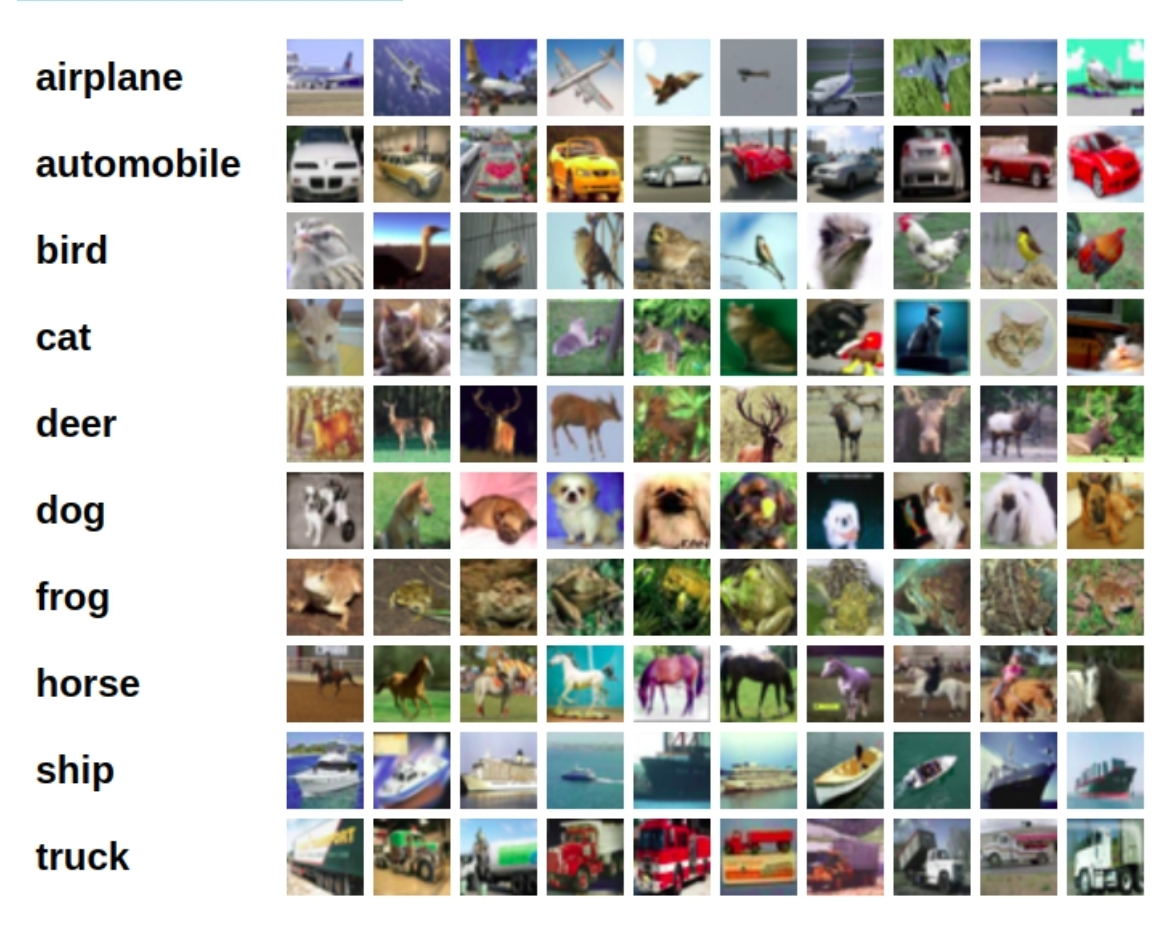

## 0. Import libraries

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Load the Dataset

The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [27]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

The following numbered labels represent the labels in the dataset:

In [28]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

# 2. Data Examination

Fistly, lets have a look and the couple of images we have,

In [29]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels_encoded = y_data[selected_ind]
  selected_labels = [labels[x[0]] for x in selected_labels_encoded]

  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img)

  for id_label, label in enumerate(selected_labels):
    plt.text((32/2) + 32*id_label - len(label), 32*(5/4), label)
  plt.axis('off')
  plt.show()

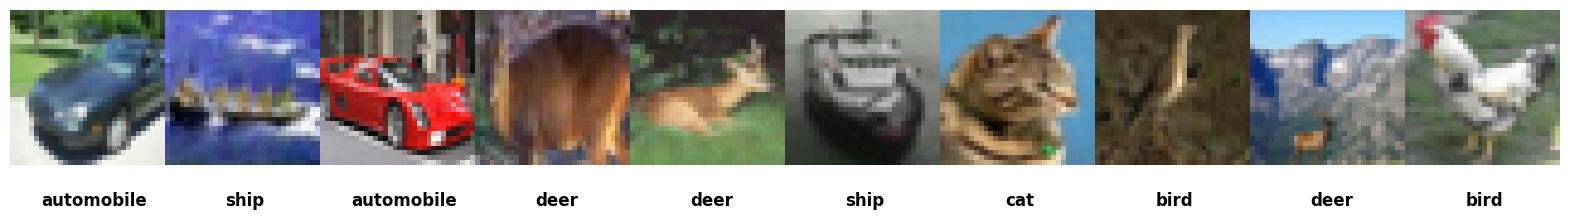

In [6]:
display_random_images(X_train, y_train)

In [30]:
#check the shape of image dataset

X_train.shape

(50000, 32, 32, 3)

In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity. With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

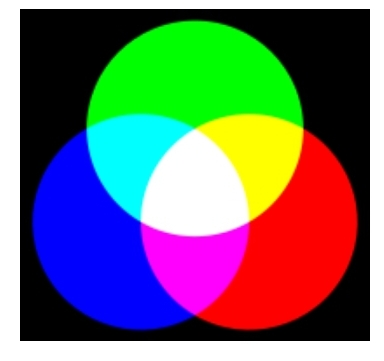

Here you can display each channel separately:

In [31]:
def display_channels_separately(image: np.array) -> None:

  plt.figure()
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))


  axs[0].imshow(image[:,:,0],cmap='Reds')
  axs[1].imshow(image[:,:,1],cmap='Blues')
  axs[2].imshow(image[:,:,2],cmap='Greens')

  axs[3].imshow(image)

  plt.show()

<Figure size 640x480 with 0 Axes>

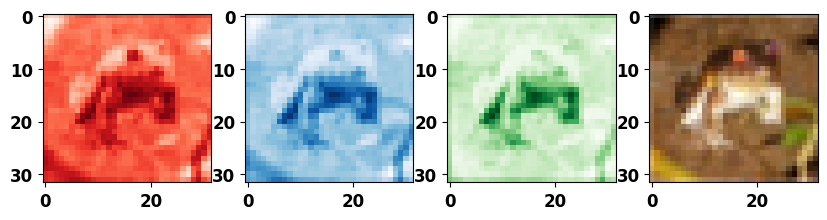

In [32]:
display_channels_separately(X_train[0])

## 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [10]:
X_train_scaled = X_train.astype('float32') / 255.0

We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [11]:
y_train_encoded = to_categorical(y_train, num_classes=10)

## 4. Define the model architecture

In [33]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(3072, activation='gelu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will define the Sequential model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the input_dim parameter in our first hidden layer, we will create a Flatten layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a softmax activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         786,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3072)                │         789,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          30,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,606,922 (6.13 MB)

 Trainable params: 1,606,922 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile our model, we will use categorical_crossentropy as a loss function, stochastic gradient descend as an optimisation and we will be checking the accuracy metric.

In [35]:
optimizer = Adamax(learning_rate = 0.01, epsilon = 0.2, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

In [36]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=100, validation_split = 0.2)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2445 - loss: 2.0627 - val_accuracy: 0.3513 - val_loss: 1.8176
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3582 - loss: 1.8031 - val_accuracy: 0.3889 - val_loss: 1.7353
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3893 - loss: 1.7239 - val_accuracy: 0.4156 - val_loss: 1.6686
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4118 - loss: 1.6584 - val_accuracy: 0.4303 - val_loss: 1.6104
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4218 - loss: 1.6184 - val_accuracy: 0.4389 - val_loss: 1.5810
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4398 - loss: 1.5806 - val_accuracy: 0.4453 - val_loss: 1.5907
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.4450 - loss: 1.5578 - val_accuracy: 0.4246 - val_loss: 1.5953
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4556 - loss: 1.5277 - 

## 6. Model evaluation

In [37]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [38]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 1.2897711992263794
Test accuracy: 55.19000291824341 %


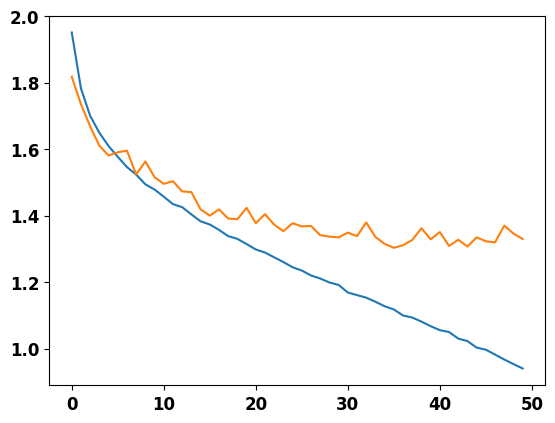

In [39]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

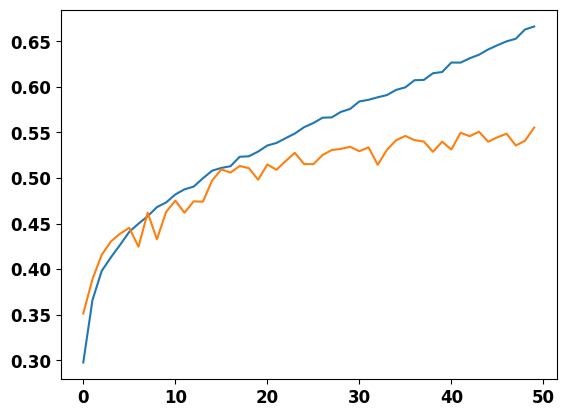

In [41]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

In [47]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


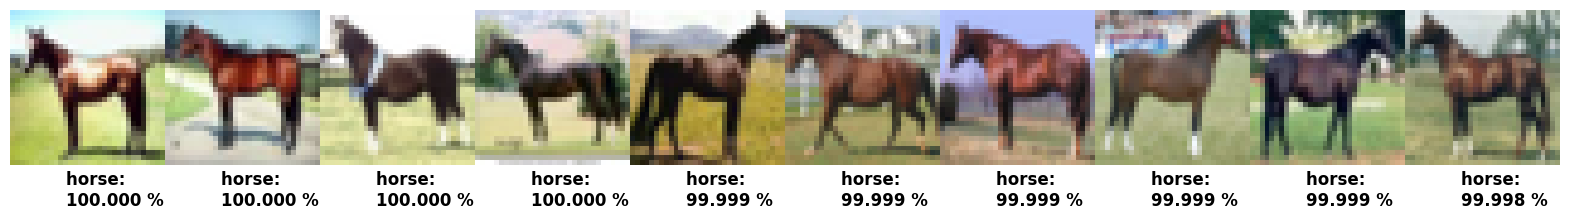

In [48]:
show_the_best_predictions(model, X_test, y_test)

## Task Description:

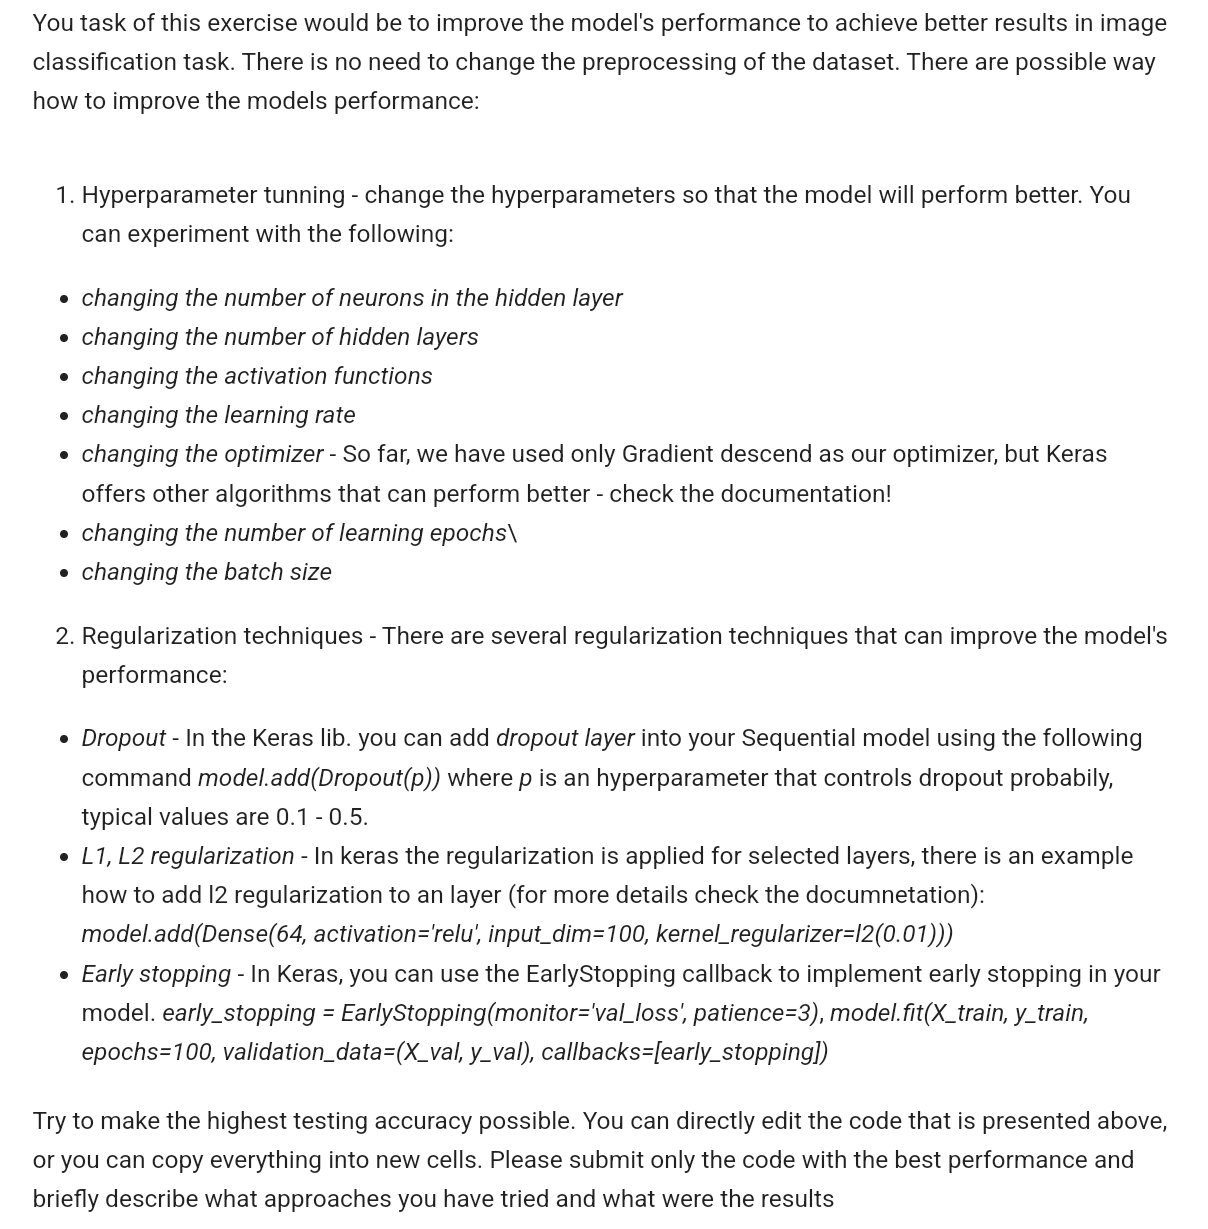

# WRITE YOUR DESCRIPTION IN THIS CELL


To improve accuracy, I adjusted parameters (learning rate, batch, epochs) and activation functions (ReLU, GeLU). I changed the optimizer to Adamax and tuned parameters. Adding layers and increasing epochs had little effect. The final accuracy was 55%, with the best recognition of horses.



## Voluntary task:

Implement one of the hyperparameter tunning algorithms discussed in the lecture, such as Grid Search, Random Search or more sophisticated ones. Some of these algorithms are already included in the Keras. Check the documentation